In [1]:
import pickle

import joblib
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the dataset
data = pd.read_csv(
    r"C:\Users\user\OneDrive - National University of Singapore\Desktop\Y4S1\DSA4264\DSA4264-Detoxify\model-1\training_data_5k.csv"
)

In [3]:
# Update class-to-id mapping for 7 classes
label_mapping = {
    "No Hate/Toxic": 0,
    "Hate 1": 1,
    "Hate 2": 2,
    "Hate 3": 3,
    "Toxic 1": 4,
    "Toxic 2": 5,
    "Toxic 3": 6,
}
# Encode gold labels
data["Classification"] = data["Classification"].astype(str)
data["Classification"] = data["Classification"].map(label_mapping)
data["text"] = data["text"].astype(str)

In [4]:
# Divide features and labels
X = data["text"]
y = data["Classification"]

In [5]:
# Split dataset into training, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

### Text Processing Function ###

In [6]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download("punkt_tab")
nltk.download("wordnet")

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()


def preprocess(text):
    # Tokenization
    words = word_tokenize(text.lower())

    # Remove punctuation and non-alphabetic tokens
    words = [word for word in words if word.isalpha()]

    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    return " ".join(words)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Preprocess the training and test data
X_train_proc = [preprocess(text) for text in X_train]
X_test_proc = [preprocess(text) for text in X_test]
X_valid_proc = [preprocess(text) for text in X_valid]

In [8]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train_proc)

X_valid_vectorized = vectorizer.transform(X_valid_proc)
X_test_vectorized = vectorizer.transform(X_test_proc)

In [ ]:
# save  vectorizer
joblib.dump(vectorizer, "vectorizer.pkl")

In [9]:
print(y_train.value_counts())

Classification
3    3500
2    3500
1    3500
0    3500
5    3500
6    3500
4    3500
Name: count, dtype: int64


## Classification Models ##

### RidgeClassifierCV ###

In [10]:
# Train the classifier
clf = RidgeClassifierCV(class_weight="balanced")
# clf.fit(X_train_balanced, y_train_balanced)
clf.fit(X_train_vectorized, y_train)


# Predict on the validation data
y_val_pred_ridge = clf.predict(X_valid_vectorized)

# Evaluate the predictions on validation data
print("Validation Accuracy: %s" % accuracy_score(y_valid, y_val_pred_ridge))
print(
    "Validation F1-Score: %s" % f1_score(y_valid, y_val_pred_ridge, average="weighted")
)
print(
    "Validation Classification Report:\n",
    classification_report(
        y_valid, y_val_pred_ridge, target_names=list(label_mapping.keys())
    ),
)


# Predict on the test data
y_pred_ridge = clf.predict(X_test_vectorized)

# Evaluate the predictions on test data
print("Test Accuracy: %s" % accuracy_score(y_test, y_pred_ridge))
print("Test F1-Score: %s" % f1_score(y_test, y_pred_ridge, average="weighted"))
print(
    "Test Classification Report:\n",
    classification_report(
        y_test, y_pred_ridge, target_names=list(label_mapping.keys())
    ),
)

Validation Accuracy: 0.7043809523809523
Validation F1-Score: 0.7080352980971947
Validation Classification Report:
                precision    recall  f1-score   support

No Hate/Toxic       0.54      0.68      0.60       750
       Hate 1       0.62      0.67      0.64       750
       Hate 2       0.98      0.80      0.88       750
       Hate 3       0.99      0.96      0.98       750
      Toxic 1       0.47      0.34      0.39       750
      Toxic 2       0.46      0.57      0.51       750
      Toxic 3       0.99      0.91      0.95       750

     accuracy                           0.70      5250
    macro avg       0.72      0.70      0.71      5250
 weighted avg       0.72      0.70      0.71      5250

Test Accuracy: 0.7051428571428572
Test F1-Score: 0.709180168663289
Test Classification Report:
                precision    recall  f1-score   support

No Hate/Toxic       0.55      0.67      0.61       750
       Hate 1       0.62      0.69      0.66       750
       Hate 2  

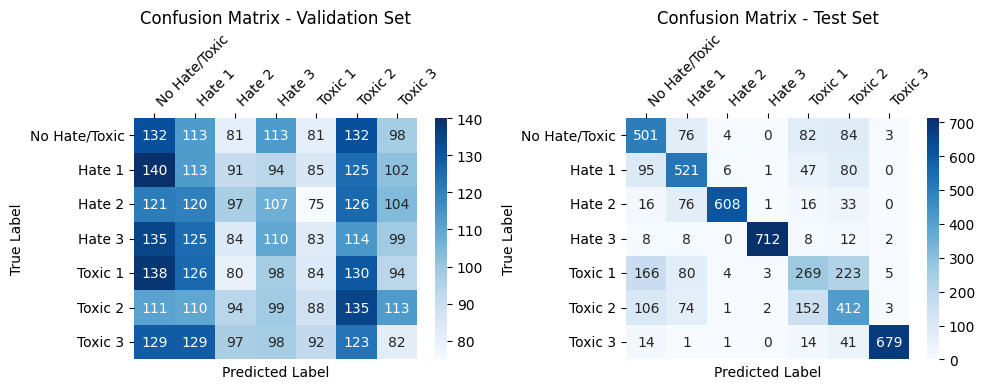

In [14]:
# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_valid, y_val_pred_ridge)

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_ridge)

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # <-- Added this line

# Plot the confusion matrix for validation set
ax = sns.heatmap(
    conf_matrix_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[0],  # <-- Specify the subplot
)
ax.set_title("Confusion Matrix - Validation Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, ha="left"
)  # <-- Fix rotation for axes[0]

# Plot the confusion matrix for test set
ax = sns.heatmap(
    conf_matrix_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[1],  # <-- Specify the subplot
)
ax.set_title("Confusion Matrix - Test Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, ha="left"
)  # <-- Fix rotation for axes[1]

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
# Save the trained model to a file
joblib.dump(clf, "ridge_classifier_model.pkl")
print("Model saved as ridge_classifier_model.pkl")

### XGBoost ###

In [ ]:
pipeline = Pipeline(
    [
        (
            "xgb",
            xgb.XGBClassifier(
                objective="multi:softmax",  # Multiclass classification
                num_class=7,  # Number of classes (7)
                eval_metric="mlogloss",  # Multiclass log-loss as evaluation metric
                use_label_encoder=False,  # Disable label encoding warning
            ),
        ),
    ]
)

# Define parameter grid for GridSearchCV (for both TF-IDF and XGBoost)
param_grid = {
    "xgb__max_depth": [3, 5],  # Control the complexity of the trees
    "xgb__learning_rate": [0.1, 0.2],  # Speed of model learning
    "xgb__n_estimators": [100, 150],  # Number of trees in the ensemble
    "xgb__subsample": [0.7, 1.0],  # Subsampling for robustness
}
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings to sample
    scoring="accuracy",  # Metric to optimize
    cv=2,  # 3-fold cross-validation
    verbose=1,  # Print progress
    n_jobs=-1,  # Use all available cores
)
# # Set up GridSearchCV
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     scoring="accuracy",
#     cv=2,  # 3-fold cross-validation for speed
#     verbose=1,  # Show progress
#     n_jobs=-1,  # Use all available cores
# )

# Fit the grid search to the raw text data
# grid_search.fit(X_train_balanced, y_train_balanced)
# grid_search.fit(X_train_vectorized, y_train)
random_search(X_train_vectorized, y_train)

# Get the best parameters found by GridSearchCV
# print("Best parameters found:", grid_search.best_params_)
print("Best parameters found:", random_search.best_params_)

# Predict on the test data using the best model
# y_pred_best = grid_search.best_estimator_.predict(X_test_vectorized)
y_pred_best = random_search.best_estimator_.predict(X_test_vectorized)

# Print accuracy and classification report
print("Accuracy: %s" % accuracy_score(y_test, y_pred_best))
print(
    classification_report(y_test, y_pred_best, target_names=list(label_mapping.keys()))
)
print("Test F1-Score weighted: %s" % f1_score(y_test, y_pred_best, average="weighted"))

# Optional: Predict on the validation set to evaluate performance
y_val_pred_best = random_search.best_estimator_.predict(X_valid_vectorized)
print("Validation Accuracy: %s" % accuracy_score(y_valid, y_val_pred_best))
print(
    classification_report(
        y_valid, y_val_pred_best, target_names=list(label_mapping.keys())
    )
)
print(
    "Validation F1-Score weighted: %s"
    % f1_score(y_valid, y_val_pred_best, average="weighted")
)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\Users\user\OneDrive - National University of Singapore\Desktop\Y4S1\DSA4264\DSA4264-Detoxify\penv\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 150, 'xgb__subsample': 1.0}
Accuracy: 0.7017142857142857
               precision    recall  f1-score   support

No Hate/Toxic       0.50      0.71      0.58       750
       Hate 1       0.66      0.65      0.65       750
       Hate 2       0.97      0.82      0.89       750
       Hate 3       0.99      0.95      0.97       750
      Toxic 1       0.44      0.37      0.40       750
      Toxic 2       0.50      0.50      0.50       750
      Toxic 3       0.98      0.91      0.94       750

     accuracy                           0.70      5250
    macro avg       0.72      0.70      0.71      5250
 weighted avg       0.72      0.70      0.71      5250

Test F1-Score weighted: 0.7059732296745951
Validation Accuracy: 0.14666666666666667
               precision    recall  f1-score   support

No Hate/Toxic       0.15      0.21      0.17       750
       Hate 1       0.14      0.13      0.14   

In [ ]:
# Save the best model (the entire pipeline with TF-IDF and XGBoost) to a file
joblib.dump(grid_search.best_estimator_, "best_tfidf_xgb_model.pkl")
print("Model saved as best_tfidf_xgb_model.pkl")

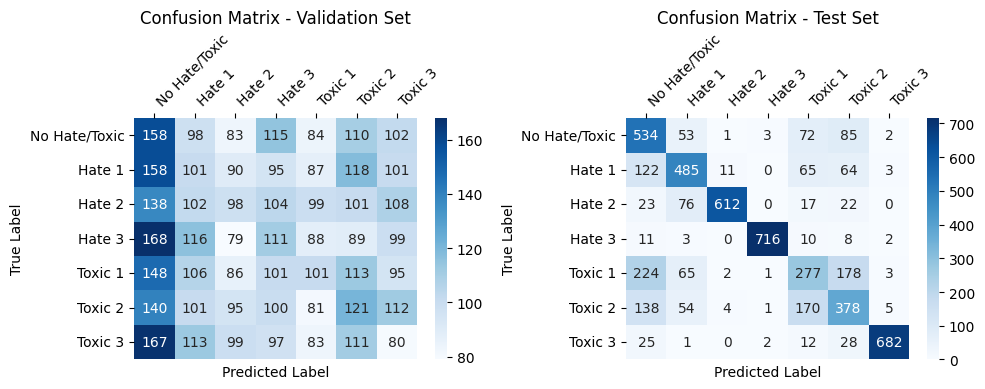

In [17]:
# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_valid, y_val_pred_best)
# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_best)
# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # <-- Added this line

# Plot the confusion matrix for validation set
ax = sns.heatmap(
    conf_matrix_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[0],  # <-- Specify the subplot
)
ax.set_title("Confusion Matrix - Validation Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, ha="left"
)  # <-- Fix rotation for axes[0]

# Plot the confusion matrix for test set
ax = sns.heatmap(
    conf_matrix_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[1],  # <-- Specify the subplot
)
ax.set_title("Confusion Matrix - Test Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, ha="left"
)  # <-- Fix rotation for axes[1]

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Naive Bayes Classifier ###

Multinomial Naive Bayes classifier - A generative classifier which models how a class could generate some input data. Given an observation, they return the class most likely to have generated the observation

In [12]:
# Create a pipeline with Multinomial Naive Bayes classifier
nb = Pipeline(
    [
        ("clf", MultinomialNB()),
    ]
)

# Fit the model to the training data
# nb.fit(X_train_balanced, y_train_balanced)
nb.fit(X_train_vectorized, y_train)

# Predict on the validation set
y_pred_nb = nb.predict(X_test_vectorized)
y_val_pred_nb = nb.predict(X_valid_vectorized)

# Evaluate the predictions
print("Test Accuracy: %s" % accuracy_score(y_pred_nb, y_test))
print("Test F1-Score: %s" % f1_score(y_test, y_pred_nb, average="weighted"))
print(classification_report(y_test, y_pred_nb, target_names=list(label_mapping.keys())))
print("Validation Accuracy: %s" % accuracy_score(y_val_pred_nb, y_valid))
print("Validation F1-Score: %s" % f1_score(y_valid, y_val_pred_nb, average="weighted"))
print(
    classification_report(
        y_valid, y_val_pred_nb, target_names=list(label_mapping.keys())
    )
)

Test Accuracy: 0.6963809523809524
Test F1-Score: 0.702446032630166
               precision    recall  f1-score   support

No Hate/Toxic       0.60      0.53      0.56       750
       Hate 1       0.60      0.74      0.66       750
       Hate 2       0.97      0.81      0.89       750
       Hate 3       0.99      0.95      0.97       750
      Toxic 1       0.43      0.40      0.41       750
      Toxic 2       0.44      0.55      0.49       750
      Toxic 3       0.98      0.91      0.94       750

     accuracy                           0.70      5250
    macro avg       0.72      0.70      0.70      5250
 weighted avg       0.72      0.70      0.70      5250

Validation Accuracy: 0.6944761904761905
Validation F1-Score: 0.6993536915643985
               precision    recall  f1-score   support

No Hate/Toxic       0.59      0.55      0.57       750
       Hate 1       0.57      0.70      0.63       750
       Hate 2       0.96      0.80      0.88       750
       Hate 3       0.99

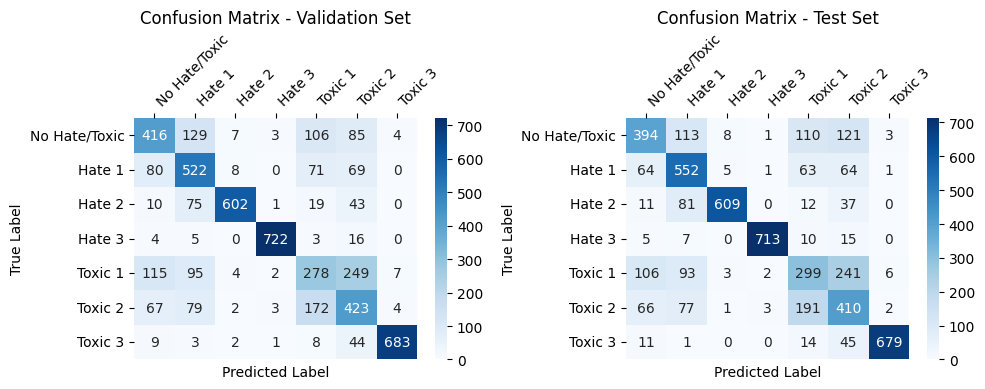

In [13]:
# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_valid, y_val_pred_nb)
# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_nb)
# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # <-- Added this line

# Plot the confusion matrix for validation set
ax = sns.heatmap(
    conf_matrix_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[0],  # <-- Specify the subplot
)
ax.set_title("Confusion Matrix - Validation Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, ha="left"
)  # <-- Fix rotation for axes[0]

# Plot the confusion matrix for test set
ax = sns.heatmap(
    conf_matrix_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[1],  # <-- Specify the subplot
)
ax.set_title("Confusion Matrix - Test Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, ha="left"
)  # <-- Fix rotation for axes[1]

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Linear SVM ###

In [11]:
# Create a pipeline with CountVectorizer, TfidfTransformer, and SGDClassifier
sgd = Pipeline(
    [
        # ("vect", CountVectorizer()),  # Convert text to a matrix of token counts
        # ("tfidf", TfidfTransformer()),  # Apply TF-IDF transformation
        (
            "clf",
            SGDClassifier(
                loss="hinge",
                penalty="l2",
                alpha=1e-3,
                random_state=42,
                max_iter=5,
                tol=None,
            ),
        ),  # Linear SVM
    ]
)

# Fit the model to the training data
sgd.fit(X_train_vectorized, y_train)

# Predict on the validation set
y_pred_svm = sgd.predict(X_test_vectorized)
y_val_pred_svm = sgd.predict(X_valid_vectorized)

# Evaluate the predictions
print("Test Accuracy: %s" % accuracy_score(y_pred_svm, y_test))
print("Test F1-Score: %s" % f1_score(y_test, y_pred_svm, average="weighted"))
print(
    classification_report(y_test, y_pred_svm, target_names=list(label_mapping.keys()))
)
print("Validation Accuracy: %s" % accuracy_score(y_val_pred_svm, y_valid))
print("Validation F1-Score: %s" % f1_score(y_valid, y_val_pred_svm, average="weighted"))
print(
    classification_report(
        y_valid, y_val_pred_svm, target_names=list(label_mapping.keys())
    )
)

Test Accuracy: 0.6666666666666666
Test F1-Score: 0.6483268416270078
               precision    recall  f1-score   support

No Hate/Toxic       0.55      0.61      0.58       750
       Hate 1       0.59      0.71      0.64       750
       Hate 2       0.73      0.82      0.78       750
       Hate 3       0.87      0.95      0.91       750
      Toxic 1       0.45      0.21      0.29       750
      Toxic 2       0.49      0.45      0.47       750
      Toxic 3       0.84      0.91      0.88       750

     accuracy                           0.67      5250
    macro avg       0.65      0.67      0.65      5250
 weighted avg       0.65      0.67      0.65      5250

Validation Accuracy: 0.6699047619047619
Validation F1-Score: 0.6503526977438704
               precision    recall  f1-score   support

No Hate/Toxic       0.55      0.62      0.58       750
       Hate 1       0.57      0.70      0.63       750
       Hate 2       0.76      0.81      0.79       750
       Hate 3       0.8